In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import pandas as pd

In [ ]:
# Set the sampling frequency
Fs = 44100

# Read first row of the text file containing the synthesis parameters using numpy
data = np.loadtxt('g1_s1_beed_est_l.txt', max_rows=1)

Nf, n = data[:-1].astype(int)
dt = data[-1].astype(float)

# Get the amplitude and frequency values and store in an ndarray
data = np.loadtxt('g1_s1_beed_est_l.txt', skiprows=1)

# Get the amplitude and frequency values and store in an ndarray
an = data[0::2, :].astype(float)
fn = data[1::2, :].astype(float)


In [ ]:
def sos_interp(a, f, Fs, dt):
    """
        Interpolates the signal values of an input partial from its amplitude and frequency values
        Adapted from sosinterp.m by Franklin Agsaway, 2005
    """

    NperFrame = round(dt * Fs)      # number of samples per frame (original sample length per frame == 44100 * 0.015986 = 705 samples)
    dt = NperFrame / Fs
    Nf = len(a)     # number of frames 

    dA = np.append(np.diff(a), -a[-1]) / NperFrame     # amplitude increment per sample 
    # Amplitude synthesis interpolation
    asyn = np.zeros(Nf * NperFrame)    # Each row in Ats represents the interpolated amp values of each partial
    asyn[::NperFrame] = a
    for i in range(1, NperFrame):
        asyn[i::NperFrame] = asyn[(i-1)::NperFrame] + dA
    # Frequency synthesis interpolation
    fsyn = np.zeros(NperFrame * Nf)  # Each row in Fts represents the frame-varying freq values of each partial
    for i in range(NperFrame):
        fsyn[i::NperFrame] = f
    # Phase synthesis interpolation
    startphase = 0
    p = np.zeros(Nf)
    for i in range(Nf):
        p[i] = startphase - 2 * np.pi * ((i) * dt) * f[i]
        startphase += 2 * np.pi * dt * f[i]

    psyn = np.zeros(NperFrame * Nf)  # Each row in Fts represents the frame-varying freq values of each partial
    for i in range(NperFrame):
        psyn[i::NperFrame] = p

    t = np.arange(0, dt * Nf, 1 / Fs)
    sig = asyn * np.sin(2 * np.pi * fsyn * t + psyn)

    return sig

In [85]:
def sos_interp2(a, f, Fs, dt):
    """
        Interpolates the signal values of an input partial from its amplitude and frequency values
        Adapted from sosinterp.m by Franklin Agsaway, 2005
    """

    
    NperFrame = round(dt * Fs)      # number of samples per frame (original sample length per frame == 44100 * 0.015986 = 705 samples)
    dt = NperFrame / Fs
    Nf = len(a)     # number of frames 

    # Amplitude synthesis interpolation
    a_interp = np.interp(np.arange(0, NperFrame * Nf), np.arange(0, NperFrame * Nf, NperFrame), a)
    # Frequency synthesis interpolation
    f_interp = np.repeat(f, NperFrame)

    f_interp = np.interp(np.arange(0, NperFrame * Nf), np.arange(0, NperFrame * Nf, NperFrame), f)
    startphase = 0
    p = np.zeros(Nf)
    for i in range(Nf):
        p[i] = startphase - 2 * np.pi * ((i) * dt) * f[i]
        startphase += 2 * np.pi * dt * f[i]
    # Interpolate p to get p_interp using numpy
    p_interp = np.interp(np.arange(0, NperFrame * Nf), np.arange(0, NperFrame * Nf, NperFrame), p)

    t = np.arange(0, dt * Nf, 1 / Fs)
    sig = a_interp * np.sin(2 * np.pi * f_interp * t + p_interp)

    return sig

In [117]:
# sos
sig = np.zeros(71910) 
for i in range(1, len(an)):
    partial = sos_interp(an[i], fn[i], Fs, dt)
    sig = sig + partial

# sos2
sig2 = np.zeros(71910)
for i in range(1, len(an)):
    partial = sos_interp2(an[i], fn[i], Fs, dt)
    sig2 = sig2 + partial


# calculate the error between the two signals
error = np.sum(np.abs(sig - sig2))
print(error)

89.90604755568461


In [116]:
sd.play(sig, Fs)

In [112]:
# play the sound
sd.play(sig2, Fs)

In [ ]:
a = an[13]
f = fn[13]

NperFrame = round(dt * Fs)      # number of samples per frame (original sample length per frame == 44100 * 0.015986 = 705 samples)
dt = NperFrame / Fs
Nf = len(a)     # number of frames 

dA = np.append(np.diff(a), -a[-1]) / NperFrame     # amplitude increment per sample 
# Amplitude synthesis interpolation
asyn = np.zeros(Nf * NperFrame)    # Each row in Ats represents the interpolated amp values of each partial
asyn[::NperFrame] = a
for i in range(1, NperFrame):
    asyn[i::NperFrame] = asyn[(i-1)::NperFrame] + dA
# Frequency synthesis interpolation
fsyn = np.zeros(NperFrame * Nf)  # Each row in Fts represents the frame-varying freq values of each partial
for i in range(NperFrame):
    fsyn[i::NperFrame] = f
# Phase synthesis interpolation
startphase = 0
p = np.zeros(Nf)
for i in range(Nf):
    p[i] = startphase - 2 * np.pi * ((i) * dt) * f[i]
    startphase += 2 * np.pi * dt * f[i]

psyn = np.zeros(NperFrame * Nf)  # Each row in Fts represents the frame-varying freq values of each partial
for i in range(NperFrame):
    psyn[i::NperFrame] = p

# Amplitude synthesis interpolation
a_interp = np.interp(np.arange(0, NperFrame * Nf), np.arange(0, NperFrame * Nf, NperFrame), a)
# Frequency synthesis interpolation
f_interp = np.repeat(f, NperFrame)



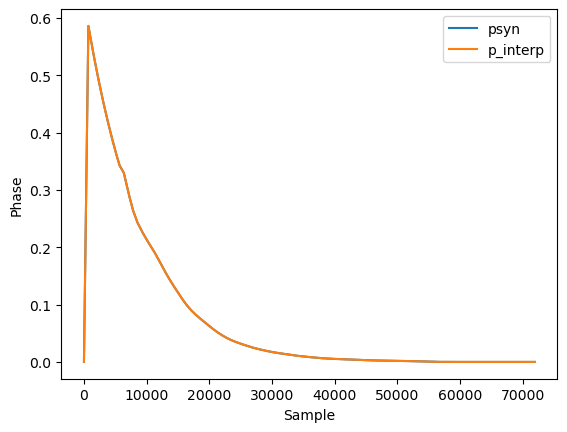

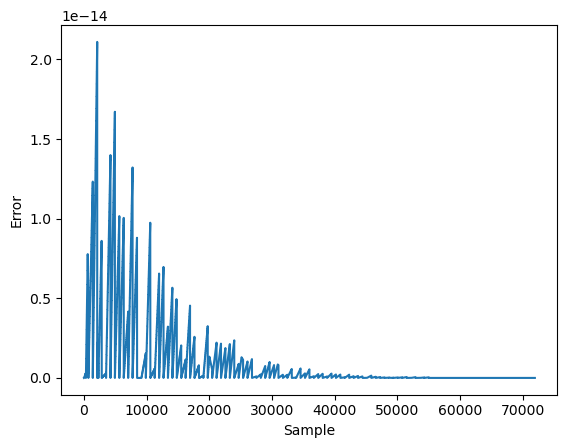

9.929093440862809e-16


In [118]:
# calculate error between fsyn and f_interp and plot the two in one graph
error = np.abs(fsyn - f_interp)
plt.plot(fsyn)
plt.plot(f_interp)
# add labels
plt.xlabel('Sample')
plt.ylabel('Phase')
plt.legend(['psyn', 'p_interp'])
plt.show()
# plot error
plt.plot(error)
plt.xlabel('Sample')
plt.ylabel('Error')
plt.show()
# calculate rmse between fsyn and f_interp
print(error.mean())

